In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
from sklearn.metrics import roc_curve


## Gaussian Generative Model:

We are working with a dataset ${\bold{x_n}, t_n}$, where n=1,...,N. Here $t_n=1$ for $C_1$ and $t_n=0$ for $C_2$. 
The posterior probability for the class $C_1$ given observations $\bold{x}$ can be written as:

$$ p(C_1 | x) = \sigma (\bold{w}^T\bold{x} + w_0) \tag{4.65}$$

where

$$ \sigma (a) = \frac{1}{1 + \text{exp}(-a) \tag{4.59}}$$
$$ \bold{w} = \Sigma^{-1} (\mu_1 - \mu_2)  \tag{4.66}$$
$$ w_0 = - \frac{1}{2} \mu_1^T \Sigma^{-1} \mu_1 + \frac{1}{2} \mu_2^T \Sigma^{-1} \mu_2 + \text{ln}\frac{p(C_1)}{p(C_2)} \tag{4.67} $$

Let $\theta$ be some threshold value. If $ p(C_1 | x) \ge \theta$, we will choose $t_n = 1$. Else, $t_n = 0$. 


### Getting parameters for $w_0$ and $\bold{w}$:

We denote the prior class probability $p(C_1)=\pi$, so that $p(C_2)=1−\pi$. By logging the likelihood function of equation 4.71, we get the log likelihood function:

$$ \sum_{n=1}^{N} \{ t_{n} \text{ln}(\pi) + (1 - t_{n})\text{ln}(1 - \pi) \}  \tag{4.72}$$

Setting the derivative wrt $\pi$ equal to zero, we get

$$ \pi = \frac{1}{N} \sum_{n=1}^{N} t_{n} = \frac{N_{1}}{N} = \frac{N_{1}}{N_{1} + N_{2}}. \tag{4.73}$$

Other MLEs:

$$ \mu_1 = \frac{1}{N_1} \sum_{n=1}^{N} t_n x_n \tag{4.75}$$
$$ \mu_1 = \frac{1}{N_2} \sum_{n=1}^{N} (1 - t_n) x_n \tag{4.76}$$
$$ S_1 = \frac{1}{N_1} \sum_{n\in C_1} (x_n - \mu_1)(x_n - \mu_1)^T\tag{4.79}$$
$$ S_2 = \frac{1}{N_2} \sum_{n\in C_2} (x_n - \mu_2)(x_n - \mu_2)^T\tag{4.80}$$

We also know that $\bold{\Sigma} = \bold{S} = \frac{N_1}{N}S_1 + \frac{N_2}{N}S_2 $.  

In [8]:
# https://www.kaggle.com/datasets/l3llff/banana
bananas_df = pd.read_csv('/home/lizocf/bayesian-ece-474/3-linear-classification/banana_quality.csv')
bananas_df.head()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,-1.924968,0.468078,3.077832,-1.472177,0.294799,2.435570,0.271290,Good
1,-2.409751,0.486870,0.346921,-2.495099,-0.892213,2.067549,0.307325,Good
2,-0.357607,1.483176,1.568452,-2.645145,-0.647267,3.090643,1.427322,Good
3,-0.868524,1.566201,1.889605,-1.273761,-1.006278,1.873001,0.477862,Good
4,0.651825,1.319199,-0.022459,-1.209709,-1.430692,1.078345,2.812442,Good


# Create Sample Observations

In [10]:
mu1 = np.array([1, 1])
mu2 = np.array([-1, -1])
sigma = np.eye(2)

size = 1000
split = 0.5

C1 = np.random.multivariate_normal(mu1, sigma, int(size*split))
C2 = np.random.multivariate_normal(mu2, sigma, int(size*(1-split)))  

X = np.concatenate((C1, C2))                                    # features
t = np.concatenate((np.ones(len(C1)), np.zeros(len(C2))))       # "labels"

# Helper Functions

In [11]:
def getAccuracy(preds, labels, threshold):
    pred = preds > threshold
    return np.sum(pred == labels) / len(labels)

In [66]:
def plotROC(t, preds, type=0, sample=True, ax=None):
    if ax is None:
        ax = plt.gca()

    
    lbl = '(Sample)' if sample else '(Banana)'
    
    if type == 0: # generative
        labels = f'Gaussian Generative Model {lbl}'
    else:
        labels = f'Logistic Regression Model {lbl}'
    fpr2, tpr2, threshold = roc_curve(t, preds, pos_label=1)
    dot = np.linspace(0,1,1000)

    #print(fpr2)
    ax.plot(fpr2,tpr2)
    ax.plot(dot,dot, '--')
    ax.set_title(labels)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

# Gaussian Generative Model

In [67]:
def GenerativeModel(X, t, C1, C2, ax=None, sample=True):
    if ax is None:
        ax = plt.gca()

    if sample:
        labels = ['Class 1', 'Class 2']
    else:
        labels = ['Good Banana', 'Bad Banana']

    N1 = len(C1)
    N2 = len(C2)
    N = N1 + N2

    for c1 in C1:
        ax.plot(c1[0], c1[1], 'ro', alpha=0.5, label=labels[0])
        labels[0] = None

    for c2 in C2:
        ax.plot(c2[0], c2[1], 'bo', alpha=0.5, label=labels[1])
        labels[1] = None
        
    # Equation 4.73 - get priors
    pi = N1 / (N1 + N2)

    # Equation 4.75 + 4.76 - get means
    mu_sums = [0, 0]
    for i in range(N):
        mu_sums[0] += t[i] * X[i]
        mu_sums[1] += (1 - t[i]) * X[i]

    mN =  [1 / N1 * mu_sums[0], 1 / N2 * mu_sums[1]]

    # Equation 4.78 - 4.80 - get covariance Σ = S
    SN_sums = [0, 0]
    for i in range(N1):
        SN_sums[0] += (C1[i] - mN[0]).dot((C1[i] - mN[0]).T)
    
    for i in range(N2):
        SN_sums[1] += (C2[i] - mN[1]).dot((C2[i] - mN[1]).T)

    SN = [1/N1 * SN_sums[0], 1/N2 * SN_sums[1]]
    S = [N1/N * SN[0] , N2/N * SN[1]]
    S = np.diag(S)

    #Equation 4.66, 4.67 - get w and w0
    w = np.linalg.inv(S).dot(mN[0] - mN[1])
    w0 = (-1/2)*mN[0]@np.linalg.inv(S).dot(mN[0].T) + 1/2*mN[1] @ np.linalg.inv(S) @ mN[1].T + np.log(pi/(1 - pi))

    #Equation 4.65 - use w and w0 to find posterior densities 
    a = w@X.T + w0
    output = 1/(1+np.exp(-a)) # use logistic sigmoid function to get probabilities

    thresh = 0.5 #  threshold can be adjusted if needed

    accuracy = getAccuracy(output, t, thresh)
    print(f'Gaussian Generative Model Accuracy: {accuracy}')

    # plot decision boundary
    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            Z[i, j] = 1/(1+np.exp(-(w@[X[i, j], Y[i, j]] + w0)))

    ax.contour(X, Y, Z, levels=[0.5], colors='k', linestyles='dashed')

    lbl = '(Sample)' if sample else '(Banana)'
    ax.set_title(f'Gaussian Generative Model {lbl}')
    ax.legend()

    return output

Gaussian Generative Model Accuracy: 0.915


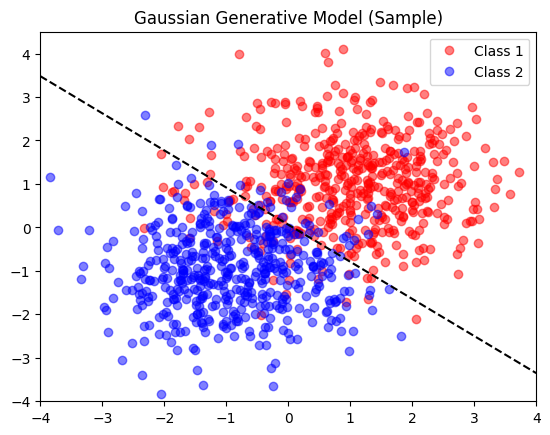

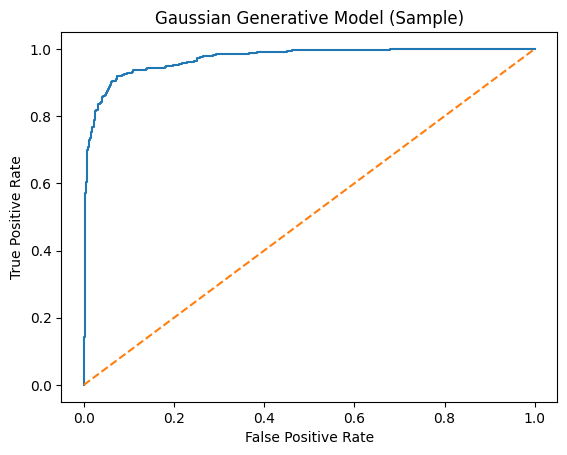

In [68]:
gen_preds = GenerativeModel(X, t, C1, C2, sample=True)
plt.show()
plotROC(t, gen_preds, type=0)

## Logistic Regression Model:

For the Logistic Regression Model, the posterior probability for the class $C_1$ given observations $\bold{x}$ can be written as:

$$ p(C_1 | x) = \sigma (\bold{w}^T\bold{x} + w_0) \tag{4.65}$$

where

In [ ]:
def LogisticModel(X, t, C1, C2, ax=None, sample=True):
    if ax is None:
        ax = plt.gca()

    if sample:
        labels = ['Class 1', 'Class 2']
    else:
        labels = ['Good Banana', 'Bad Banana']

    N1 = len(C1)
    N2 = len(C2)
    N = N1 + N2

    for c1 in C1:
        ax.plot(c1[0], c1[1], 'ro', alpha=0.5, label=labels[0])
        labels[0] = None

    for c2 in C2:
        ax.plot(c2[0], c2[1], 'bo', alpha=0.5, label=labels[1])
        labels[1] = None